In [0]:
# Importing Libraries

In [0]:
import os
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
# Data directory
os.chdir("/content/drive/HAR/HAR/UCI_HAR_Dataset") 

In [0]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import sequence
from keras.initializers import RandomNormal
from keras.initializers import glorot_uniform,glorot_normal 
from keras.layers.normalization import BatchNormalization
import sqlite3
import pandas as pd
import re
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/HAR/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/HAR/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [0]:
# Initializing parameters
epochs = 30
batch_size = 64
n_hidden = 32

# Models using Deep Learning

In [0]:
# Model for KerasClassifier
def model_(n_hidden, dropout_rate):
	  # create model
    model = Sequential()
    model.add(LSTM(n_hidden, return_sequences=True , input_shape=(timesteps, input_dim), kernel_initializer='glorot_normal'))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(n_hidden, kernel_initializer='glorot_normal'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, kernel_initializer='glorot_normal', activation='sigmoid'))
	
    print(model.summary())
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    

    return model

In [0]:
# Hyper parameter tuning the LSTM model using GridSearchCV
modela = KerasClassifier(build_fn=model_, epochs=30, batch_size=64, verbose=1)

# parameters for Gridsearchcv 
n_hidden = [128, 164, 186, 212]
dropout_rate = [0.3, 0.4, 0.5, 0.6, 0.7]

param_grid = dict(n_hidden=n_hidden, dropout_rate=dropout_rate)

gscv = GridSearchCV(estimator=modela, param_grid=param_grid)
gscv_res = gscv.fit(X_train, Y_train, validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 203,014
Trainable params: 203,014
Non-trainable params: 0
_________________________________________________________________
None
Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 36s 7ms/step - loss: 1.4408

Here after Hyperparameter tuning the LSTM architecture maximum accuracy is approx 90%. So instead of LSTM some other DL model needs to be used, eg. CNN (which is implemented below)

In [0]:
input_shape = (timesteps, input_dim, 1)
X_train = X_train.reshape(X_train.shape[0], timesteps, input_dim, 1)
X_test = X_test.reshape(X_test.shape[0], timesteps, input_dim, 1)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 9, 128)       1280      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 9, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 4, 128)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 4, 64)         73792     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 4, 32)         18464     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 2, 32)         128       
__________

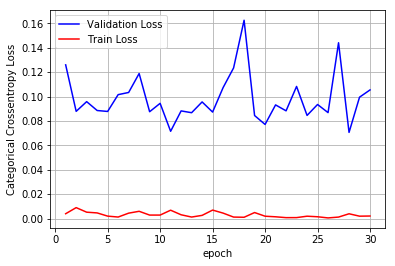

In [0]:
# MODEL 1
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])
model.summary()
history_ = model1.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score_ = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_[0])
print('Test accuracy:', score_[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,30+1))
vy = history_.history['val_loss']
ty = history_.history['loss']
plt_dynamic(x, vy, ty, ax)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 9, 84)        1428      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 9, 84)        112980    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 4, 84)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 4, 42)         56490     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 4, 42)         28266     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 2, 42)         0         
_________________________________________________________________
flat

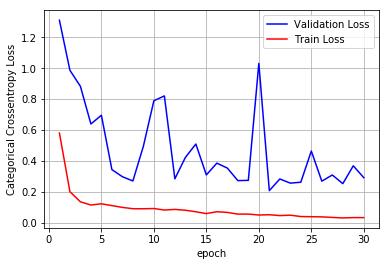

In [0]:
# MODEL 2
modela = Sequential()
modela.add(Conv2D(84, kernel_size=(4, 4),activation='relu', padding='same', input_shape=input_shape))
modela.add(Conv2D(84, (4, 4), activation='relu', padding='same'))
modela.add(MaxPooling2D(pool_size=(2, 2)))


modela.add(Conv2D(42, (4, 4), activation='relu', padding='same'))
modela.add(Conv2D(42, (4, 4), activation='relu', padding='same'))
modela.add(MaxPooling2D(pool_size=(2, 2)))

modela.add(Flatten())
modela.add(Dense(80, activation='relu'))
modela.add(BatchNormalization())

modela.add(Dense(n_classes, activation='softmax'))

modela.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
modela.summary()
history_1 = modela.fit(X_train, Y_train, batch_size=256, epochs=30,verbose=1,validation_data=(X_test, Y_test))
score_1 = modela.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,30+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 128, 9, 84)        1428      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 9, 84)        112980    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 4, 84)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 4, 84)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 4, 42)         56490     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 4, 42)         28266     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 2, 42)         0         
__________

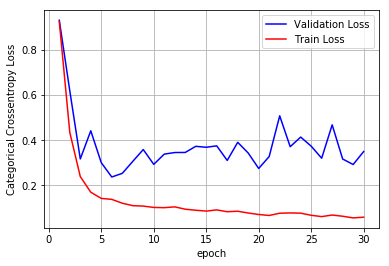

In [0]:
# MODEL 3
# Same model with dropout
modelb = Sequential()
modelb.add(Conv2D(84, kernel_size=(4, 4),activation='relu', padding='same', input_shape=input_shape))
modelb.add(Conv2D(84, (4, 4), activation='relu', padding='same'))
modelb.add(MaxPooling2D(pool_size=(2, 2)))
modelb.add(Dropout(0.4))


modelb.add(Conv2D(42, (4, 4), activation='relu', padding='same'))
modelb.add(Conv2D(42, (4, 4), activation='relu', padding='same'))
modelb.add(MaxPooling2D(pool_size=(2, 2)))
modelb.add(Dropout(0.4))

modelb.add(Flatten())
modelb.add(Dense(80, activation='relu'))
modelb.add(BatchNormalization())
modelb.add(Dropout(0.4))

modelb.add(Dense(n_classes, activation='softmax'))

modelb.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
modelb.summary()
history_1b = modelb.fit(X_train, Y_train, batch_size=256, epochs=30,verbose=1,validation_data=(X_test, Y_test))
score_1b = modelb.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_1b[0])
print('Test accuracy:', score_1b[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,30+1))
vy = history_1b.history['val_loss']
ty = history_1b.history['loss']
plt_dynamic(x, vy, ty, ax)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 128, 9, 84)        1428      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 9, 84)        112980    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 4, 84)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 4, 84)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 4, 42)         56490     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 4, 42)         28266     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 2, 42)         0         
__________

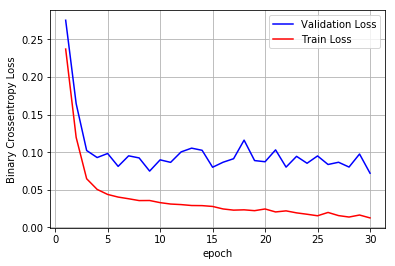

In [0]:
# MODEL 4
# Same model with Binary_crossentropy
modelb1 = Sequential()
modelb1.add(Conv2D(84, kernel_size=(4, 4),activation='relu', padding='same', input_shape=input_shape))
modelb1.add(Conv2D(84, (4, 4), activation='relu', padding='same'))
modelb1.add(MaxPooling2D(pool_size=(2, 2)))
modelb1.add(Dropout(0.4))

modelb1.add(Conv2D(42, (4, 4), activation='relu', padding='same'))
modelb1.add(Conv2D(42, (4, 4), activation='relu', padding='same'))
modelb1.add(MaxPooling2D(pool_size=(2, 2)))
modelb1.add(Dropout(0.4))

modelb1.add(Flatten())
modelb1.add(Dense(80, activation='relu'))
modelb1.add(BatchNormalization())
modelb1.add(Dropout(0.4))

modelb1.add(Dense(n_classes, activation='softmax'))

modelb1.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
modelb1.summary()
history_1b1 = modelb1.fit(X_train, Y_train, batch_size=256, epochs=30,verbose=1,validation_data=(X_test, Y_test))
score_1b1 = modelb1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_1b1[0])
print('Test accuracy:', score_1b1[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

x = list(range(1,30+1))
vy = history_1b1.history['val_loss']
ty = history_1b1.history['loss']
plt_dynamic(x, vy, ty, ax)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 128, 9, 74)        1258      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 128, 9, 74)        87690     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 4, 74)         0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 4, 74)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 64, 4, 36)         42660     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 64, 4, 36)         20772     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 2, 36)         0         
__________

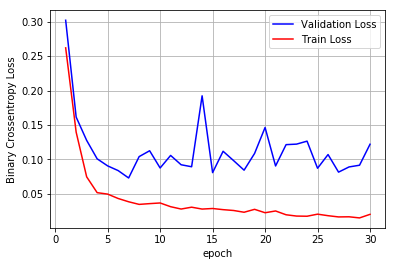

In [0]:
# MODEL 5
# Binary_crossentropy, no. of units per layer decreased
modelb2 = Sequential()
modelb2.add(Conv2D(74, kernel_size=(4, 4),activation='relu', padding='same', input_shape=input_shape))
modelb2.add(Conv2D(74, (4, 4), activation='relu', padding='same'))
modelb2.add(MaxPooling2D(pool_size=(2, 2)))
modelb2.add(Dropout(0.4))

modelb2.add(Conv2D(36, (4, 4), activation='relu', padding='same'))
modelb2.add(Conv2D(36, (4, 4), activation='relu', padding='same'))
modelb2.add(MaxPooling2D(pool_size=(2, 2)))
modelb2.add(Dropout(0.4))

modelb2.add(Flatten())
modelb2.add(Dense(80, activation='relu'))
modelb2.add(BatchNormalization())
modelb2.add(Dropout(0.4))

modelb2.add(Dense(n_classes, activation='softmax'))

modelb2.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
modelb2.summary()
history_1b2 = modelb2.fit(X_train, Y_train, batch_size=256, epochs=30,verbose=1,validation_data=(X_test, Y_test))
score_1b2 = modelb1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score_1b2[0])
print('Test accuracy:', score_1b2[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')

x = list(range(1,30+1))
vy = history_1b2.history['val_loss']
ty = history_1b2.history['loss']
plt_dynamic(x, vy, ty, ax)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 9, 64)        1664      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 9, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 4, 64)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 4, 32)         51232     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 4, 32)         25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 2, 32)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
__________

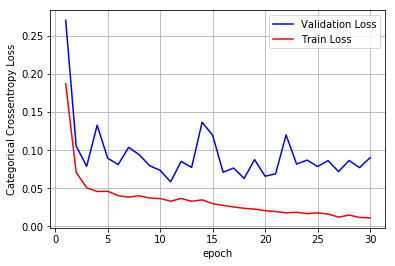

In [0]:
# MODEL 6
# categorical cross entropy
model2 = Sequential()
model2.add(Conv2D(64, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model2.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

model2.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(n_classes, activation='softmax'))

model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()
history2 = model2.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score2 = model2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))
vy = history2.history['val_loss']
ty = history2.history['loss']
plt_dynamic(x, vy, ty, ax)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 128, 9, 64)        1664      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 9, 64)        102464    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 4, 64)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 4, 32)         51232     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 4, 32)         25632     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 2, 32)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
__________

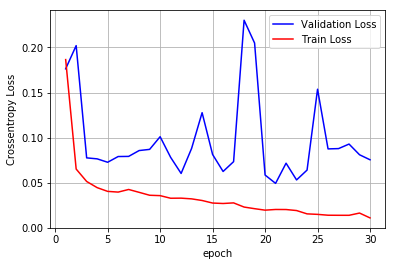

In [0]:
# MODEL 7
# Binary cross entropy
model2a = Sequential()
model2a.add(Conv2D(64, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model2a.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model2a.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

model2a.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2a.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2a.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

model2a.add(Flatten())
model2a.add(Dense(128, activation='relu'))
model2a.add(BatchNormalization())
model2a.add(Dropout(0.5))
model2a.add(Dense(n_classes, activation='softmax'))

model2a.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model2a.summary()
history2a = model2a.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score2a = model2a.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score2a[0])
print('Test accuracy:', score2a[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Crossentropy Loss')

x = list(range(1,epochs+1))
vy = history2a.history['val_loss']
ty = history2a.history['loss']
plt_dynamic(x, vy, ty, ax)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 128, 9, 64)        1664      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 128, 9, 64)        102464    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 64, 4, 64)         0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 64, 4, 64)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 4, 32)         51232     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 4, 32)         25632     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 2, 32)         0         
__________

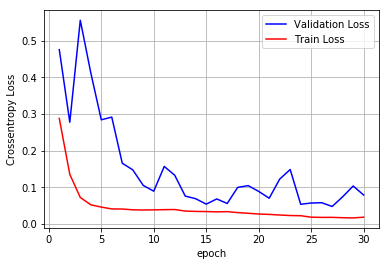

In [0]:
# MODEL 8
# with dropout = 0.4, binary crossentropy
model2b1 = Sequential()
model2b1.add(Conv2D(64, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model2b1.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model2b1.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model2b1.add(Dropout(0.4))

model2b1.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2b1.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2b1.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model2b1.add(BatchNormalization())
model2b1.add(Dropout(0.4))

model2b1.add(Flatten())
model2b1.add(Dense(100, activation='relu'))
model2b1.add(BatchNormalization())
model2b1.add(Dropout(0.4))
model2b1.add(Dense(n_classes, activation='softmax'))

model2b1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model2b1.summary()
history2b1 = model2b1.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score2b1 = model2b1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score2b1[0])
print('Test accuracy:', score2b1[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Crossentropy Loss')

x = list(range(1,epochs+1))
vy = history2b1.history['val_loss']
ty = history2b1.history['loss']
plt_dynamic(x, vy, ty, ax)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 128, 9, 64)        1664      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 128, 9, 64)        102464    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 64, 4, 64)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 64, 4, 64)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 64, 4, 32)         51232     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 4, 32)         25632     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 2, 32)         0         
__________

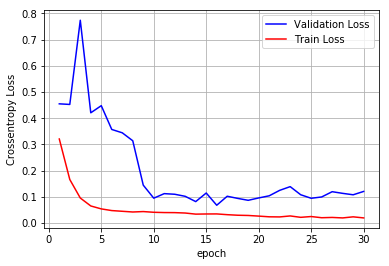

In [0]:
# MODEL 9
# with Binary cross entropy, dropout=0.5
model2b = Sequential()
model2b.add(Conv2D(64, kernel_size=(5, 5),activation='relu', padding='same', input_shape=input_shape))
model2b.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model2b.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model2b.add(Dropout(0.5))

model2b.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2b.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model2b.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model2b.add(BatchNormalization())
model2b.add(Dropout(0.5))

model2b.add(Flatten())
model2b.add(Dense(100, activation='relu'))
model2b.add(BatchNormalization())
model2b.add(Dropout(0.5))
model2b.add(Dense(n_classes, activation='softmax'))

model2b.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model2b.summary()
history2b = model2b.fit(X_train, Y_train, batch_size=256, epochs=30, verbose=1, validation_data=(X_test, Y_test))
score2b = model2b.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score2b[0])
print('Test accuracy:', score2b[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Crossentropy Loss')

x = list(range(1,epochs+1))
vy = history2b.history['val_loss']
ty = history2b.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion

In [0]:
!pip install -q PTable
from prettytable import PrettyTable 

x = PrettyTable()
x.field_names = ["Model no.", "Architecture type", "Loss (Entropy)", "Dropout" , "Test Score", "Test Accuracy"]
x.add_row([1,"Con-Con-Pool-Con-Con-Pool","Binary", "--", 0.4514, 0.8333 ])
x.add_row([2,"Con-Con-Pool-Con-Con-Pool","Categorical", "--", 0.291, 0.9355 ])
x.add_row([3,"Con-Con-Pool-Con-Con-Pool","Categorical", 0.4, 0.3499, 0.9256 ])
x.add_row([4,"Con-Con-Pool-Con-Con-Pool","Binary", 0.4, 0.0719, 0.9768 ])
x.add_row([5,"Con-Con-Pool-Con-Con-Pool","Binary", 0.4, 0.71, 0.9768 ])
x.add_row([6,"Con-Con-Pool-Con-Con-Pool","Categorical", "--", 0.90, 0.9780 ])
x.add_row([7,"Con-Con-Pool-Con-Con-Pool","Binary", "--", 0.075, 0.983 ])
x.add_row([8,"Con-Con-Pool-Con-Con-Pool","Binary", 0.4, 0.078, 0.9716 ])
x.add_row([9,"Con-Con-Pool-Con-Con-Pool","Binary", 0.5, 0.120, 0.9753 ])


print(x)

+-----------+---------------------------+----------------+---------+------------+---------------+
| Model no. |     Architecture type     | Loss (Entropy) | Dropout | Test Score | Test Accuracy |
+-----------+---------------------------+----------------+---------+------------+---------------+
|     1     | Con-Con-Pool-Con-Con-Pool |     Binary     |    --   |   0.4514   |     0.8333    |
|     2     | Con-Con-Pool-Con-Con-Pool |  Categorical   |    --   |   0.291    |     0.9355    |
|     3     | Con-Con-Pool-Con-Con-Pool |  Categorical   |   0.4   |   0.3499   |     0.9256    |
|     4     | Con-Con-Pool-Con-Con-Pool |     Binary     |   0.4   |   0.0719   |     0.9768    |
|     5     | Con-Con-Pool-Con-Con-Pool |     Binary     |   0.4   |    0.71    |     0.9768    |
|     6     | Con-Con-Pool-Con-Con-Pool |  Categorical   |    --   |    0.9     |     0.978     |
|     7     | Con-Con-Pool-Con-Con-Pool |     Binary     |    --   |   0.075    |     0.983     |
|     8     | Con-Co

1) LSTM with 2 layer was hyper-parameter tuned using GridsearchCV. The maximum accuracy (approx 90%) was not upto the mark. Hence, shifted onto CNN.

2) The CNN 1st model gave less accuracy with Binary Crossentropy and due more no. of units per layer, no. of weights are more and model significantly overfits as can be seen in the graph. 

3) So a model with less no. of units with Binary as well Categorical entropy was tried.
Model 2 gave better accuracy but was overfitting. So in Model 3 dropout (=0.4) was used, which decreased overfitting to some extent but affected the accuracy.

4) For Model 4 categorical loss is used instead of binary loss in Model 3. The accuracy increased significantly but overfitting was there. So in Model 5 no. of units per layer were decreased to reduce no. of weights, but it gave more overfitiing than Model 4.

5) In Model 6 and 7, the kernel size and stride was increased. Even though here Model 7 outperforms other models in terms of accuracy, but has significant overfitting than Model 6.  

6) In hope to reduce the overfitting and maintain the high accuracy, Model 8 and 9 with dropout 0.4, 0.5 resp were used. It reduced the overfitting, but accuracy decreased. Considering the trade-off for Accuracy and Overfitting problem, Model 9 is what I would recommend as better model of all. 











